In [ ]:
from google.colab import drive
drive.mount('/adrive')

Mounted at /adrive


# Setup

In [ ]:
!pip install -qU torch==2.6.0
!pip install -qU pynvml>=12.0.0,<13.0.0
!pip install -qU transformers>=4.41.0,<5.0.0
!pip install -qU fsspec==2023.10.0
!pip install -qU openai wandb
!pip install -qU json-repair
!pip install -qU faker
!pip install -qU vllm>=0.4.0  # Newer version compatible with torch 2.6.0
!pip install -qU qwen-vl-utils[decord]==0.0.8
!pip install -qU datasets

In [ ]:
!git clone --depth 1 https://github.com/hiyouga/LLaMA-Factory.git
!cd LLaMA-Factory && pip install -e .

In [ ]:
from google.colab import userdata
import wandb
wandb.login(key=userdata.get('w&b'))

hf_token = userdata.get('huggingface')
!huggingface-cli login --token {hf_token}

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aasel6948 (aasel6948-helwan-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
The token `Invoice` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `Invoice`


# Libs import

In [ ]:
import json
from os.path import join
import random
from tqdm.auto import tqdm
import requests
from pydantic import BaseModel, Field
from typing import List, Optional, Literal
from datetime import datetime
import json_repair
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
from transformers import AutoTokenizer, AutoProcessor,Qwen2VLForConditionalGeneration
from qwen_vl_utils import process_vision_info
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import gc
import os
import time
import base64
from datasets import load_from_disk
import io
import outlines
import re
from sklearn.metrics import precision_score, recall_score, f1_score

data_dir = "/adrive/MyDrive/Invoice_data"
base_model_id = "Qwen/Qwen2-VL-2B-Instruct"

device = "cuda"
torch_dtype = None
def parse_json(text):
    try:
        return json_repair.loads(text)
    except:
        return None

# load and resize the image

In [ ]:
def load_and_resize_image(image_path, max_size=600):

    image = Image.open(image_path)

    if max(image.size) > max_size:
        ratio = max_size / max(image.size)
        new_size = (int(image.size[0] * ratio), int(image.size[1] * ratio))
        image = image.resize(new_size, Image.LANCZOS)

    return image

#Structured output

In [ ]:
class SubItem(BaseModel):
    name: str = Field(..., description="Name of the sub item or modifier.")
    quantity: str = Field(..., description="Quantity of the sub item.")
    price: str = Field(..., description="Price of the sub item.")

class MenuItem(BaseModel):
    name: str = Field(..., description="Name of the menu item.")
    quantity: str = Field(..., description="Quantity of the menu item.")
    price: str = Field(..., description="Price of the menu item.")
    sub_items: Optional[List[SubItem]] = Field(default_factory=list, description="Sub-items or options for this menu item.")

class SubTotal(BaseModel):
    subtotal_price: str = Field(..., description="Subtotal before tax and tip.")
    tax_price: Optional[str] = Field(None, description="Tax amount.")

class Total(BaseModel):
    total_price: str = Field(..., description="Final total including tax and other fees.")
    emoneyprice: Optional[str] = Field(None, description="Amount paid via electronic money.")

class InvoiceDetails(BaseModel):
    menu: List[MenuItem] = Field(..., description="List of ordered menu items.")
    sub_total: SubTotal = Field(..., description="Subtotal of the invoice.")
    total: Total = Field(..., description="Total details of the invoice.")


In [ ]:
image_path = "/content/image_72.png"
image = load_and_resize_image(image_path)

In [ ]:
details_extraction_messages_sample = [
        {
            "role": "system",
            "content": "\n".join([
                "You are an NLP data parser.",
                "Structure the data according to the provided Pydantic schema.",
                "Extract all invoice details exactly as they appear in the text.",
                "Return ONLY valid JSON matching the provided schema, nothing else.",
                "Generate the output in the same language as the invoice.",
                "Maintain all original formatting of numerical values, dates, and amounts",
            ])
        },
          {
            "role": "user",
            "content": [
              {
                "type": "text",
                "text": "What is in this image? + <image>"
              },
              {
                "type": "text",
                "text": "Pydantic Details:\n" +
                       json.dumps(InvoiceDetails.model_json_schema(), ensure_ascii=False)
              },
              {
                "type": "image_url",
                "image_url": {
                  "url": image
                }
              }
            ]
          }

    ]

#base Model Evaluation (Qwen_2B VL)

In [ ]:
model = outlines.models.transformers_vision(
    base_model_id,
    model_class=Qwen2VLForConditionalGeneration,
     device="cuda",
)
processor = AutoProcessor.from_pretrained(base_model_id)

In [ ]:
def generate_text_from_sample(model, processor, image: Image.Image, max_new_tokens=512):
    gc.collect()
    torch.cuda.empty_cache()

    # Prepare the text prompt
    text_input = processor.apply_chat_template(
        details_extraction_messages_sample, tokenize=False, add_generation_prompt=True
    )


    # Save original CUDA visible devices setting
    original_cuda_visible_devices = os.environ.get('CUDA_VISIBLE_DEVICES', '')
    model_device = "cuda"
    try:
        os.environ['CUDA_VISIBLE_DEVICES'] = ''

        model_inputs = processor(
            text=[text_input],
            images=[image],
            return_tensors="pt"
        ).to(model_device)


        generator = outlines.generate.json(model, InvoiceDetails, sampler=outlines.samplers.greedy())
        with torch.no_grad():
            generated_ids = generator(
              text_input,
              [image]
            )

    finally:
        os.environ['CUDA_VISIBLE_DEVICES'] = original_cuda_visible_devices
        gc.collect()
        torch.cuda.empty_cache()

    return generated_ids


In [ ]:
# Start overall timer
start_time = time.time()

# Time for image extraction
start_extract = time.time()
res_image = image
end_extract = time.time()
print(f"Time for image extraction: {end_extract - start_extract:.4f} seconds")

# Time for text generation
start_gen = time.time()
output_text = generate_text_from_sample(model, processor, image=res_image, max_new_tokens=1024)
end_gen = time.time()
print(f"Time for text generation: {end_gen - start_gen:.4f} seconds")

# Final output and total time
print(output_text)
total_time = time.time() - start_time
print(f"Total time taken: {total_time:.4f} seconds")

Time for image extraction: 0.0001 seconds


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Time for text generation: 22.8517 seconds
menu=[MenuItem(name='Hakau Udang', quantity='4', price='92,000', sub_items=[]), MenuItem(name='Siaomai Babi', quantity='4', price='80,000', sub_items=[]), MenuItem(name='Ceker Ayam', quantity='3', price='60,000', sub_items=[]), MenuItem(name='Bakpao BKR C', quantity='2', price='42,000', sub_items=[]), MenuItem(name='Tahu Goreng', quantity='3', price='60,000', sub_items=[])] sub_total=SubTotal(subtotal_price='334,000', tax_price=None) total=Total(total_price='334,000', emoneyprice='350,000')
Total time taken: 22.8553 seconds


# save base Model output for the test data


In [ ]:
test_path = '/adrive/MyDrive/Invoice_data/splits/test/images'
output_file_path = '/adrive/MyDrive/Invoice_data/splits/test/base_model_out.txt'

# Get all image files
image_files = [img for img in os.listdir(test_path) if img.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".webp"))]

with open(output_file_path, 'w', encoding='utf-8') as f:
    for img in tqdm(image_files, desc="Processing images"):
        image_path = os.path.join(test_path, img)
        res_img = load_and_resize_image(image_path)
        output_text = generate_text_from_sample(model, processor, image=res_img, max_new_tokens=1024)

        # Initialize all variables as None
        total_price = None
        tax_price = None
        cashprice = None
        changeprice = None

        # Safely extract total_price if available
        try:
            if hasattr(output_text, 'total') and hasattr(output_text.total, 'total_price'):
                total_price = output_text.total.total_price
        except (AttributeError, TypeError):
            pass

        # Safely extract tax_price if available
        try:
            if hasattr(output_text, 'sub_total') and hasattr(output_text.sub_total, 'tax_price'):
                tax_price = output_text.sub_total.tax_price
        except (AttributeError, TypeError):
            pass

        # Safely extract cashprice if available
        try:
            if hasattr(output_text, 'total') and hasattr(output_text.total, 'cashprice'):
                cashprice = output_text.total.cashprice
        except (AttributeError, TypeError):
            pass

        # Safely extract changeprice if available
        try:
            if hasattr(output_text, 'total') and hasattr(output_text.total, 'changeprice'):
                changeprice = output_text.total.changeprice
        except (AttributeError, TypeError):
            pass

        result = [total_price, tax_price, cashprice, changeprice]
        f.write(f"{img}: {result}\n")

Processing images:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
with open(output_file_path, 'r', encoding='utf-8') as f:
    for i in range(100):
        line = f.readline()
        print(line.strip())

image_0.png: ['60.000', '5.455', None, None]
image_1.png: ['91000', None, None, None]
image_2.png: ['28.000', None, None, None]
image_3.png: ['11,000', None, None, None]
image_4.png: ['174,600', None, None, None]
image_5.png: ['31.00', None, None, None]
image_6.png: ['46,000', None, None, None]
image_7.png: ['111,000', '10,091', None, None]
image_8.png: ['50000', '45455', None, None]
image_9.png: ['36000', 'null', None, None]
image_10.png: ['17,000', None, None, None]
image_11.png: ['230,000', None, None, None]
image_12.png: ['120000', None, None, None]
image_13.png: ['46.636', None, None, None]
image_14.png: ['281,435', None, None, None]
image_15.png: ['63.000', None, None, None]
image_16.png: ['70,000', '6,364', None, None]
image_17.png: ['91,000', None, None, None]
image_18.png: ['156000', None, None, None]
image_19.png: ['176000', None, None, None]
image_20.png: ['377,859', None, None, None]
image_21.png: ['38.000', None, None, None]
image_22.png: ['100,000', None, None, None]
imag

# Note: The Qwen Model here it can't ;
- extract something like the change price or
tax
- some prices

# Dataset naver-clova-ix/cord-v2

In [ ]:
# Load the CORD-V2 dataset from Hugging Face
dataset = load_dataset("naver-clova-ix/cord-v2")

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

(…)-00000-of-00004-b4aaeceff1d90ecb.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00001-of-00004-7dbbe248962764c5.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

(…)-00002-of-00004-688fe1305a55e5cc.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

(…)-00003-of-00004-2d0cd200555ed7fd.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

(…)-00000-of-00001-cc3c5779fe22e8ca.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

(…)-00000-of-00001-9c204eb3f4e11791.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
# Print dataset structure
print("Dataset structure:")
print(dataset)

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})


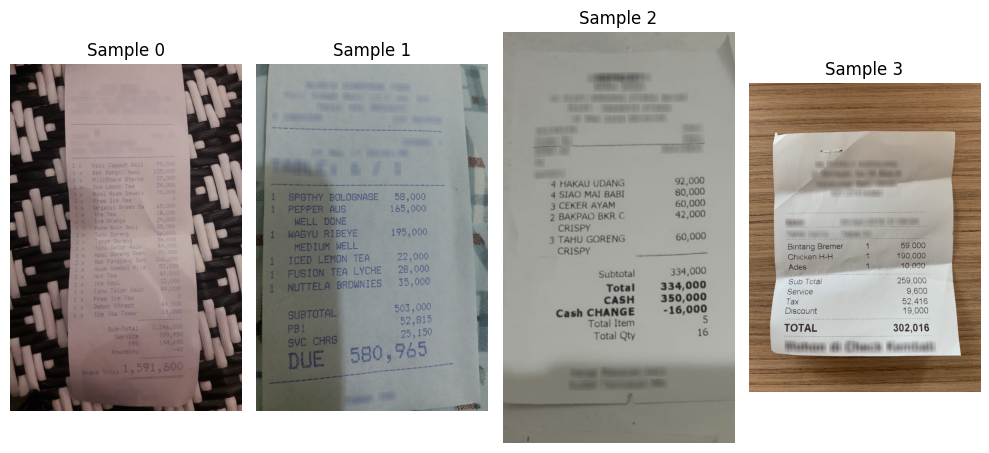

In [ ]:
train_dataset = dataset["train"]

# Function to plot images
def plot_images(dataset, num_images=2):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        image = dataset[i]['image']  # Already a PIL Image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Sample {i}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Plot two images from the train split
plot_images(train_dataset, num_images=4)

In [ ]:
# Function to print JSON data for the images
def print_image_json(dataset, num_images=2):
    for i in range(num_images):
        print(f"\n--- JSON for Sample {i} ---")
        for key, value in dataset[i].items():
            if key != "image":  # Skip the image object itself
                print(f"{key}: {value}")
print_image_json(train_dataset, num_images=4)



--- JSON for Sample 0 ---
ground_truth: {"gt_parse": {"menu": [{"nm": "Nasi Campur Bali", "cnt": "1 x", "price": "75,000"}, {"nm": "Bbk Bengil Nasi", "cnt": "1 x", "price": "125,000"}, {"nm": "MilkShake Starwb", "cnt": "1 x", "price": "37,000"}, {"nm": "Ice Lemon Tea", "cnt": "1 x", "price": "24,000"}, {"nm": "Nasi Ayam Dewata", "cnt": "1 x", "price": "70,000"}, {"nm": "Free Ice Tea", "cnt": "3 x", "price": "0"}, {"nm": "Organic Green Sa", "cnt": "1 x", "price": "65,000"}, {"nm": "Ice Tea", "cnt": "1 x", "price": "18,000"}, {"nm": "Ice Orange", "cnt": "1 x", "price": "29,000"}, {"nm": "Ayam Suir Bali", "cnt": "1 x", "price": "85,000"}, {"nm": "Tahu Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tempe Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tahu Telor Asin", "cnt": "1 x", "price": "40,000."}, {"nm": "Nasi Goreng Samb", "cnt": "1 x", "price": "70,000"}, {"nm": "Bbk Panggang Sam", "cnt": "3 x", "price": "366,000"}, {"nm": "Ayam Sambal Hija", "cnt": "1 x", "price": "92,000"

# Save Data to Drive

In [ ]:
# # Step 2: Define your local save path
# save_path = "/adrive/MyDrive/Invoice_data"

# # Step 3: Save the dataset to disk
# dataset.save_to_disk(save_path)

# print(f"CORD-V2 dataset saved to {save_path}")

In [ ]:
from datasets import load_from_disk

# Load the saved dataset
save_path = "/adrive/MyDrive/Invoice_data"  # your path
dataset = load_from_disk(save_path)
# Show the first sample
sample = dataset['train'][1]
print(sample)

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=864x1296 at 0x7904A93230D0>, 'ground_truth': '{"gt_parse": {"menu": [{"nm": "SPGTHY BOLOGNASE", "cnt": "1", "price": "58,000"}, {"nm": "PEPPER AUS", "cnt": "1", "price": "165,000", "sub": {"nm": "WELL DONE"}}, {"nm": "WAGYU RIBEYE", "cnt": "1", "price": "195,000", "sub": {"nm": "MEDIUM WELL"}}, {"nm": "ICED LEMON TEA", "cnt": "1", "price": "22,000"}, {"nm": "FUSION TEA LYCHE", "cnt": "1", "price": "28,000"}, {"nm": "NUTTELA BROWNIES", "cnt": "1", "price": "35,000"}], "sub_total": {"subtotal_price": "503,000", "service_price": "25,150", "tax_price": "52,815"}, "total": {"total_price": "580,965"}}, "meta": {"version": "2.0.0", "split": "train", "image_id": 1, "image_size": {"width": 864, "height": 1296}}, "valid_line": [{"words": [{"quad": {"x2": 74, "y3": 512, "x3": 74, "y4": 512, "x1": 56, "y1": 480, "x4": 56, "y2": 480}, "is_key": 0, "row_id": 2252526, "text": "1"}], "category": "menu.cnt", "group_id": 3, "sub_group_id": 0

# make the data as jsonl format

In [ ]:
print(len(dataset['train']))

800


In [ ]:
def resize_image(image: Image.Image, max_size: int = 600) -> Image.Image:
    """
    Resize the input PIL image if its largest dimension exceeds max_size.

    Args:
        image (PIL.Image.Image): The input image.
        max_size (int): The maximum allowed size for the longest side.

    Returns:
        PIL.Image.Image: The resized image (or the original if resizing wasn't needed).
    """
    if max(image.size) > max_size:
        ratio = max_size / max(image.size)
        new_size = (int(image.size[0] * ratio), int(image.size[1] * ratio))
        return image.resize(new_size, Image.LANCZOS)
    return image

In [ ]:
# Load the saved dataset
save_path = "/adrive/MyDrive/Invoice_data"  # your path
dataset = load_from_disk(save_path)
splits = ['train','test','validation']

output_dir = "/adrive/MyDrive/Invoice_data/splits"

for split in splits:
    split_output_dir = os.path.join(output_dir, split)
    os.makedirs(split_output_dir, exist_ok=True)

    # Create images directory for this split
    images_dir = os.path.join(split_output_dir, "images")
    os.makedirs(images_dir, exist_ok=True)

    jsonl_path = os.path.join(split_output_dir, f"{split}.jsonl")
    with open(jsonl_path, 'w', encoding='utf-8') as f_jsonl:
        for idx in range(len(dataset[split])):
            # Get image and resize
            image = dataset[split][idx]['image']
            image_resized = resize_image(image)

            # Save the image to a file
            image_filename = f"image_{idx}.png"
            image_path = os.path.join(images_dir, image_filename)
            image_resized.save(image_path)

            # Use a relative path in the JSON (easier to move around)
            relative_image_path = os.path.join("images", image_filename)

            # Get ground truth
            sample = dataset[split][idx]['ground_truth']
            if isinstance(sample, str):
                sample_dict = json.loads(sample)
                gt_parse = sample_dict.get("gt_parse", {})
            else:
                gt_parse = sample.get("gt_parse", {})
            image_abs_path = os.path.join("/adrive/MyDrive/Invoice_data/splits", split, relative_image_path)
            # Create JSON object with image path instead of base64
            article = {
                "image": image_abs_path ,  # Format expected by Llama Factory
                "task": "Extract the invoice details into a JSON." + "<image>",
                "answer": json.dumps(gt_parse, ensure_ascii=False),
                "output_scheme": json.dumps(InvoiceDetails.model_json_schema(), ensure_ascii=False)
            }

            f_jsonl.write(json.dumps(article, ensure_ascii=False) + '\n')


# Read splits

In [ ]:
data_dir = "/adrive/MyDrive/Invoice_data/splits"

In [ ]:
train_data_path = join(data_dir,"train","train.jsonl")
test_data_path = join(data_dir,"test","test.jsonl")
val_data_path = join(data_dir,"validation","validation.jsonl")

raw_data = []
for split_path in [train_data_path,test_data_path,val_data_path]:
  for line in open(split_path):
      if line.strip() == "":
          continue

      raw_data.append(
          json.loads(line.strip())
      )

  #random.Random(101).shuffle(raw_data)
  print(f"Raw data: in {split_path} {len(raw_data)}")
  raw_data[0]
  raw_data.clear()

Raw data: in /adrive/MyDrive/Invoice_data/splits/train/train.jsonl 800
Raw data: in /adrive/MyDrive/Invoice_data/splits/test/test.jsonl 100
Raw data: in /adrive/MyDrive/Invoice_data/splits/validation/validation.jsonl 100


# Read JSONL data

In [ ]:
raw_data_path = join(data_dir,"train","train.jsonl")

raw_data = []
for line in open(raw_data_path):
    if line.strip() == "":
        continue

    raw_data.append(
        json.loads(line.strip())
    )

random.Random(101).shuffle(raw_data)

print(f"Raw data: {len(raw_data)}")

Raw data: 800


In [ ]:
str(raw_data[0]['image'])

'/adrive/MyDrive/Invoice_data/splits/train/images/image_501.png'

# Structure for LLama Factory

In [ ]:
system_message = "\n".join([
    "You are a professional NLP data parser.",
    "Follow the provided `Task` by the user and the `Output Scheme` to generate the `Output JSON`.",
    "Do not generate any introduction or conclusion."
    "Extract all invoice details exactly as they appear in the text.",

])

In [ ]:
def make_tuning_data(llm_path):
    llm_finetunning_data = []
    for line in open(llm_path):
            if line.strip() == "":
                continue

            rec = json.loads(line.strip())
            images = []
            llm_finetunning_data.append({
                "system": system_message,
                "instruction": "\n".join([
                    "# Task:",
                    rec["task"],

                    "# Output Scheme:",
                    rec["output_scheme"],
                    "",

                    "# Output JSON:"
                    "```json"

                ]),
                "images" : [rec["image"]],

                "input": "",
                "output": "\n".join([ # parse
                    "```json",
                    json.dumps(rec["answer"], ensure_ascii=False, default=str),
                    "```"
                ]),
                "history": []
            })

    return llm_finetunning_data

In [ ]:
train_data_path = join(data_dir,"train","train.jsonl")
test_data_path = join(data_dir,"test","test.jsonl")
val_data_path = join(data_dir,"validation","validation.jsonl")

llm_train = []
llm_test = []
llm_val = []
splits = ['train','test','validation']


for split in splits:
  if (split == 'train'):
    llm_train = make_tuning_data(train_data_path)
    random.Random(101).shuffle(llm_train)
  elif (split == 'test'):
    llm_test = make_tuning_data(test_data_path)
    random.Random(101).shuffle(llm_test)
  else:
   llm_val = make_tuning_data(val_data_path)
   random.Random(101).shuffle(llm_val)


In [ ]:
len(llm_train) , len(llm_test) , len(llm_val)

(800, 100, 100)

In [ ]:
llm_train[1]

{'system': 'You are a professional NLP data parser.\nFollow the provided `Task` by the user and the `Output Scheme` to generate the `Output JSON`.\nDo not generate any introduction or conclusion.Extract all invoice details exactly as they appear in the text.',
 'instruction': '# Task:\nExtract the invoice details into a JSON.<image>\n# Output Scheme:\n{"$defs": {"MenuItem": {"properties": {"name": {"description": "Name of the menu item.", "title": "Name", "type": "string"}, "quantity": {"description": "Quantity of the menu item.", "title": "Quantity", "type": "string"}, "price": {"description": "Price of the menu item.", "title": "Price", "type": "string"}, "sub_items": {"anyOf": [{"items": {"$ref": "#/$defs/SubItem"}, "type": "array"}, {"type": "null"}], "description": "Sub-items or options for this menu item.", "title": "Sub Items"}}, "required": ["name", "quantity", "price"], "title": "MenuItem", "type": "object"}, "SubItem": {"properties": {"name": {"description": "Name of the sub 

# make the array splits jsons

In [ ]:
# Save each list as a JSON file
with open(os.path.join(data_dir,"train", "llm_train.json"), "w") as f:
    json.dump(llm_train, f, indent=2)

with open(os.path.join(data_dir,"test", "llm_test.json"), "w") as f:
    json.dump(llm_test, f, indent=2)

with open(os.path.join(data_dir, "validation","llm_val.json"), "w") as f:
    json.dump(llm_val, f, indent=2)

In [ ]:
# Load the converted JSON file
json_path = join(data_dir, "train", "llm_train.json")
with open(json_path, 'r') as f:
    train_data = json.load(f)

# Extract the first sample
sample = train_data[0]

# Extract image path and load the image
image_path = sample['images'][0] # Adjust this key if your JSON uses a different one
img = Image.open(image_path).convert("RGB")

print(image_path,("\n"),sample)

/adrive/MyDrive/Invoice_data/splits/train/images/image_501.png 
 {'system': 'You are a professional NLP data parser.\nFollow the provided `Task` by the user and the `Output Scheme` to generate the `Output JSON`.\nDo not generate any introduction or conclusion.Extract all invoice details exactly as they appear in the text.', 'instruction': '# Task:\nExtract the invoice details into a JSON.<image>\n# Output Scheme:\n{"$defs": {"MenuItem": {"properties": {"name": {"description": "Name of the menu item.", "title": "Name", "type": "string"}, "quantity": {"description": "Quantity of the menu item.", "title": "Quantity", "type": "string"}, "price": {"description": "Price of the menu item.", "title": "Price", "type": "string"}, "sub_items": {"anyOf": [{"items": {"$ref": "#/$defs/SubItem"}, "type": "array"}, {"type": "null"}], "description": "Sub-items or options for this menu item.", "title": "Sub Items"}}, "required": ["name", "quantity", "price"], "title": "MenuItem", "type": "object"}, "Sub

#Make llama factory Config

1. add data to the /content/LLaMA-Factory/data/dataset_info.json
2. make yaml file fot fine-tuning configs

In [ ]:
   "invoice_train": {
        "file_name": "/adrive/MyDrive/Invoice_data/splits/train/llm_train.json",
        "columns": {
            "prompt": "instruction",
            "query": "input",
            "response": "output",
            "system": "system",
            "history": "history",
            "images": "images"
        }
    },
    "invoice_val": {
        "file_name": "/adrive/MyDrive/Invoice_data/splits/validation/llm_val.json",
        "columns": {
            "prompt": "instruction",
            "query": "input",
            "response": "output",
            "system": "system",
            "history": "history",
            "images": "images"
        }
    }

In [ ]:
%%writefile /content/LLaMA-Factory/examples/train_lora/invoice_finetune.yaml

### model
model_name_or_path: Qwen/Qwen2-VL-2B-Instruct
trust_remote_code: true

### method
stage: sft
do_train: true
finetuning_type: lora
lora_rank: 64
lora_target: all

### dataset
dataset: invoice_train
eval_dataset: invoice_val
template: qwen2_vl
cutoff_len: 3500
#max_samples: 5
overwrite_cache: true
preprocessing_num_workers: 16

### output
# resume_from_checkpoint: /adrive/MyDrive/LLM_data/llm-finetuning/models/checkpoint-1500
output_dir: /adrive/MyDrive/Invoice_data/llm-finetuning/models/
logging_steps: 10
save_steps: 200
plot_loss: true
# overwrite_output_dir: true

### train
per_device_train_batch_size: 1
gradient_accumulation_steps: 4
learning_rate: 1.0e-4
num_train_epochs: 3.0
lr_scheduler_type: cosine
warmup_ratio: 0.1
bf16: true
ddp_timeout: 180000000

### eval
# val_size: 0.1
per_device_eval_batch_size: 1
eval_strategy: steps
eval_steps: 100

report_to: wandb
run_name: invoive-finetune-llamafactory

push_to_hub: true
export_hub_model_id: "Alawy21/Invoice-analyzer(Qwen3B_fine_tune)"
hub_private_repo: true
#hub_strategy: checkpoint


Overwriting /content/LLaMA-Factory/examples/train_lora/invoice_finetune.yaml


In [ ]:
!cd LLaMA-Factory/ && llamafactory-cli train /content/LLaMA-Factory/examples/train_lora/invoice_finetune.yaml

# Evaluating fine-tuned Qwen model

In [ ]:
base_model = Qwen2VLForConditionalGeneration.from_pretrained(
    base_model_id,
    device_map="auto",
    torch_dtype = torch_dtype
)
processor = AutoProcessor.from_pretrained(base_model_id)

In [ ]:
finetuned_model = "/adrive/MyDrive/Invoice_data/llm-finetuning/models/"
base_model.load_adapter(finetuned_model)

In [ ]:
def generate_text_from_lora(model, processor, image: Image.Image, max_new_tokens=512):
    gc.collect()
    torch.cuda.empty_cache()

    # Prepare the text prompt
    text_input = processor.apply_chat_template(
        details_extraction_messages_sample, tokenize=False, add_generation_prompt=True
    )

    # Save original CUDA visible devices setting
    original_cuda_visible_devices = os.environ.get('CUDA_VISIBLE_DEVICES', '')
    model_device = next(model.parameters()).device
    try:
        os.environ['CUDA_VISIBLE_DEVICES'] = ''

        model_inputs = processor(
            text=[text_input],
            images=[image],
            return_tensors="pt"
        ).to(model_device)


        if model_device.type != 'cpu':
            print("Warning: Model is on CUDA. Move to CPU if needed.")

        with torch.no_grad():
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                use_cache=True,
            )

            trimmed_generated_ids = [out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]
            output_text = processor.batch_decode(
                trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )

    finally:
        os.environ['CUDA_VISIBLE_DEVICES'] = original_cuda_visible_devices
        gc.collect()
        torch.cuda.empty_cache()

    return output_text[0]


In [ ]:
# Start overall timer
start_time = time.time()

# Time for image extraction
start_extract = time.time()
res_image = image
end_extract = time.time()
print(f"Time for image extraction: {end_extract - start_extract:.4f} seconds")

# Time for text generation
start_gen = time.time()
output_text = generate_text_from_lora(base_model, processor, image=res_image, max_new_tokens=1024)
end_gen = time.time()
print(f"Time for text generation: {end_gen - start_gen:.4f} seconds")

# Final output and total time
print(output_text)
total_time = time.time() - start_time
print(f"Total time taken: {total_time:.4f} seconds")

Time for image extraction: 0.0001 seconds


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Time for text generation: 10.6572 seconds
```json
"{\"menu\": {\"nm\": \"Choco Devil\", \"cnt\": \"1\", \"price\": \"15,909\"}, \"sub_total\": {\"subtotal_price\": \"15,909\", \"tax_price\": \"1,591\"}, \"total\": {\"total_price\": \"17,500\", \"cashprice\": \"20,000\", \"changeprice\": \"2,500\"}}"
```
Total time taken: 10.6578 seconds


# Save lora Model output on the test split

# Repair Function

In [ ]:
def fix_broken_json_string(s):
    s = s.strip()

    # Remove escaped quotes like \" (they were likely double escaped)
    s = s.replace('\\"', '"')

    # Ensure it starts and ends with curly braces
    if not s.startswith('{'):
        s = '{' + s
    if not s.endswith('}'):
        s = s + '}'

    # Add missing double quote at beginning of the first key
    s = re.sub(r'^{([^"}]+)":', r'{"\1":', s)

    # Ensure all keys are quoted
    s = re.sub(r'([{,])\s*([a-zA-Z0-9_]+)\s*:', r'\1"\2":', s)

    # Escape double quotes inside string values (e.g., Goblin"s Mace -> Goblin\"s Mace)
    def escape_inner_quotes(match):
        key, value = match.group(1), match.group(2)
        # Only escape unescaped quotes inside the string value
        value = re.sub(r'(?<!\\)"', r'\\"', value)
        return f'"{key}": "{value}"'

    s = re.sub(r'"([^"]+)":\s*"([^"]*?)"', escape_inner_quotes, s)

    # Convert (0) -> "0" or strip parentheses
    s = re.sub(r'"\(([^)]+)\)"', r'"\1"', s)

    return s


In [ ]:
test_path = '/adrive/MyDrive/Invoice_data/splits/test/images'
output_file_path = '/adrive/MyDrive/Invoice_data/splits/test/lora_model_out.txt'

# Get all image files
image_files = [img for img in os.listdir(test_path) if img.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".webp"))]

with open(output_file_path, 'w', encoding='utf-8') as f:
    for img in tqdm(image_files, desc="Processing images"):
        image_path = os.path.join(test_path, img)
        res_img = load_and_resize_image(image_path)
        output_text = generate_text_from_lora(base_model, processor, image=res_img, max_new_tokens=1024)

        # Initialize all variables as None
        total_price = None
        tax_price = None
        cashprice = None
        changeprice = None
        parsed = parse_json(output_text)
        raw_str = list(parsed.keys())[0]
        actual_data = fix_broken_json_string(raw_str)
        actual_data = json.loads(actual_data)
        try:
            if 'total' in actual_data and 'total_price' in actual_data['total']:
                  total_price = actual_data['total']['total_price']
        except (AttributeError, TypeError):
            pass

        # Safely extract tax_price if available
        try:
            if 'sub_total' in actual_data and 'tax_price' in actual_data['sub_total']:
                  tax_price = actual_data['sub_total']['tax_price']
        except (AttributeError, TypeError):
            pass

        # Safely extract cashprice if available
        try:
            if 'total' in actual_data and 'cashprice' in actual_data['total']:
                  cashprice = actual_data['total']['cashprice']
        except (AttributeError, TypeError):
            pass

        # Safely extract changeprice if available
        try:
            if 'total' in actual_data and 'changeprice' in actual_data['total']:
                  changeprice = actual_data['total']['changeprice']
        except (AttributeError, TypeError):
            pass

        result = [total_price, tax_price, cashprice, changeprice]
        f.write(f"{img}: {result}\n")

Processing images:   0%|          | 0/100 [00:00<?, ?it/s]

# Extract True Labels

In [ ]:
# Path to your input JSON file
json_file_path = "/adrive/MyDrive/Invoice_data/splits/test/llm_test.json"
output_text_path = "/adrive/MyDrive/Invoice_data/splits/test/test_models_output/true_labels.txt"

def clean_json_string(json_str):
    """
    Extract the JSON string inside the triple backticks and clean escape characters.
    """
    try:
        # Extract content inside ```json\n ... \n```
        match = re.search(r"```json\s*(.*?)\s*```", json_str, re.DOTALL)
        if not match:
            return None
        raw_json = match.group(1).strip()

        # If it starts with a double-quoted string (escaped JSON), unescape it
        if raw_json.startswith('"'):
            raw_json = json.loads(raw_json)  # decode one layer of escaped JSON

        # Now parse the cleaned JSON
        return json.loads(raw_json)
    except Exception as e:
        print("Failed to parse output:", e)
        return None

results = []

with open(json_file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

with open(output_text_path, "w", encoding="utf-8") as f:
    # Sort the samples by the image number (extracted from the image path)
    data.sort(key=lambda x: int(re.search(r'(\d+)', x.get("images", [""])[0]).group(1)))

    for sample in data:
        image_path = sample.get("images", [""])[0].split("/")[-1]
        output_field = sample.get("output", "")
        parsed_json = clean_json_string(output_field)

        if not parsed_json:
            f.write(f"{image_path}: ERROR_PARSING_JSON\n")
            continue

        # Safely extract desired values with fallback to None
        total_price = parsed_json.get("total", {}).get("total_price")
        tax_price = parsed_json.get("sub_total", {}).get("tax_price")
        cashprice = parsed_json.get("total", {}).get("cashprice")
        changeprice = parsed_json.get("total", {}).get("changeprice")

        result = [total_price, tax_price, cashprice, changeprice]
        f.write(f"{image_path}: {result}\n")

# Make the three outputs have unified format to compare

In [ ]:
def process_file(file_path, output_dir):
    """
    Process the text file by replacing decimal points with commas and removing non-numeric characters.
    Saves the result in a new file in the specified output directory.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    processed_lines = []
    for line in lines:
        # Extract the image name and the values
        image_name, values_str = line.split(":", 1)
        values = eval(values_str.strip())  # Convert the list string to an actual list

        # Process the list to replace decimal points with commas and remove non-numeric characters
        processed_values = []
        for value in values:
            if value is not None:
                # Convert to string and replace decimal points with commas, removing non-numeric characters except commas
                processed_value = re.sub(r'[^\d.]', '', str(value))  # Remove non-numeric characters (except decimal points)
                processed_value = processed_value.replace('.', ',')  # Replace decimal point with comma
                processed_values.append(processed_value)
            else:
                processed_values.append(None)

        # Rebuild the line with processed values
        processed_line = f"{image_name}: {processed_values}\n"
        processed_lines.append(processed_line)

    # Generate a new file name based on the original file name
    base_name = os.path.basename(file_path)
    output_file_name = f"processed_{base_name}"
    output_file_path = os.path.join(output_dir, output_file_name)

    # Write the processed lines to the new file
    with open(output_file_path, "w", encoding="utf-8") as file:
        file.writelines(processed_lines)

    print(f"Processed file saved as: {output_file_path}")

# List of file paths to process
file_paths = [
    "/adrive/MyDrive/Invoice_data/splits/test/test_models_output/base_model_out.txt",
    "/adrive/MyDrive/Invoice_data/splits/test/test_models_output/lora_model_out.txt",
    "/adrive/MyDrive/Invoice_data/splits/test/test_models_output/true_labels.txt"
]

# Output directory for processed files
output_dir = "/adrive/MyDrive/Invoice_data/splits/test/test_models_output/processed/"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process each file and save to the new directory
for file_path in file_paths:
    process_file(file_path, output_dir)


Processed file saved as: /adrive/MyDrive/Invoice_data/splits/test/test_models_output/processed/processed_base_model_out.txt
Processed file saved as: /adrive/MyDrive/Invoice_data/splits/test/test_models_output/processed/processed_lora_model_out.txt
Processed file saved as: /adrive/MyDrive/Invoice_data/splits/test/test_models_output/processed/processed_true_labels.txt


# Make the Evaluation plot

# each class percentage

In [ ]:
def load_file(file_path):
    """
    Load the file and return the data in a dictionary format.
    """
    data = {}
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            image_name, values_str = line.split(":", 1)
            values = eval(values_str.strip())
            data[image_name.strip()] = values
    return data

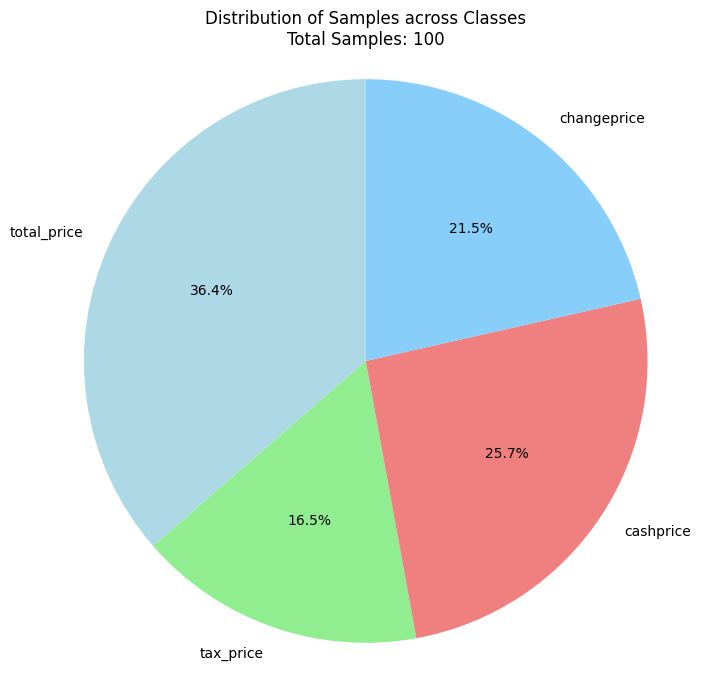

In [ ]:
def count_samples(data):
    """
    Count the number of valid (non-None) samples for each class (total_price, tax_price, etc.).
    """
    field_names = ['total_price', 'tax_price', 'cashprice', 'changeprice']
    counts = {field: 0 for field in field_names}

    # Count valid (non-None) samples for each field
    for entry in data.values():
        for i, value in enumerate(entry):
            if value is not None:
                counts[field_names[i]] += 1

    return counts

def plot_pie_chart(counts, total_samples):
    """
    Plot a pie chart based on the counts of valid samples for each class.
    """
    labels = counts.keys()
    sizes = counts.values()
    percentages = [count / total_samples * 100 for count in sizes]

    # Plotting the pie chart
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
    ax.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.

    ax.set_title(f"Distribution of Samples across Classes\nTotal Samples: {total_samples}")
    plt.show()

# File path to your data
file_path = '/adrive/MyDrive/Invoice_data/splits/test/test_models_output/processed/processed_true_labels.txt'  # Replace with your actual file path

# Parse the data from the file
data = load_file(file_path)

# Count valid samples for each class
counts = count_samples(data)

# Total number of samples (number of entries in the dictionary)
total_samples = len(data)

# Plot the pie chart
plot_pie_chart(counts, total_samples)

# Misses percentage

In [ ]:
def compare_samples(true_data, lora_data, base_data):
    """
    Compare each sample between true data and the two models (Lora and Base).
    Return a list of misses for each field.
    """
    misses = {"total_price": {"lora": 0, "base": 0}, "tax_price": {"lora": 0, "base": 0},
              "cashprice": {"lora": 0, "base": 0}, "changeprice": {"lora": 0, "base": 0}}

    for image_name, true_values in true_data.items():
        lora_values = lora_data.get(image_name, [None, None, None, None])
        base_values = base_data.get(image_name, [None, None, None, None])

        for i, field in enumerate(["total_price", "tax_price", "cashprice", "changeprice"]):
            true_value = true_values[i]
            lora_value = lora_values[i]
            base_value = base_values[i]

            # If the model's value is None and true value is not None, it's a miss
            if true_value is not None:
                if lora_value is None:
                    misses[field]["lora"] += 1
                elif lora_value != true_value:
                    misses[field]["lora"] += 1

                if base_value is None:
                    misses[field]["base"] += 1
                elif base_value != true_value:
                    misses[field]["base"] += 1

    return misses


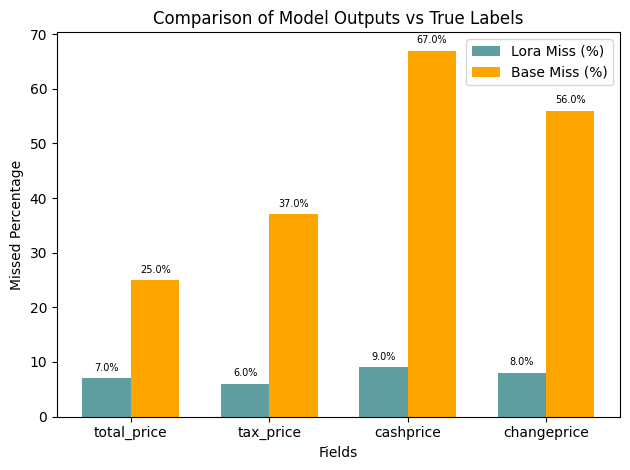

In [ ]:
def plot_comparison(misses, total_samples):
    """
    Plot a bar chart comparing the missed values for each model (side-by-side).
    """
    labels = ['total_price', 'tax_price', 'cashprice', 'changeprice']
    lora_miss_counts = [misses[field]["lora"] for field in labels]
    base_miss_counts = [misses[field]["base"] for field in labels]

    # Bar plot for comparison
    x = np.arange(len(labels))  # label positions
    width = 0.35  # bar width

    fig, ax = plt.subplots()
    lora_bars = ax.bar(x - width/2, [miss / total_samples * 100 for miss in lora_miss_counts], width, label='Lora Miss (%)', color='cadetblue')
    base_bars = ax.bar(x + width/2, [miss / total_samples * 100 for miss in base_miss_counts], width, label='Base Miss (%)', color='orange')

    # Annotate bars with percentage values
    for bar in lora_bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=7)

    for bar in base_bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=7)

    ax.set_xlabel('Fields')
    ax.set_ylabel('Missed Percentage')
    ax.set_title('Comparison of Model Outputs vs True Labels')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.tight_layout()
    plt.show()
# File paths
true_labels_path = "/adrive/MyDrive/Invoice_data/splits/test/test_models_output/processed/processed_true_labels.txt"
lora_model_out_path = "/adrive/MyDrive/Invoice_data/splits/test/test_models_output/processed/processed_lora_model_out.txt"
base_model_out_path = "/adrive/MyDrive/Invoice_data/splits/test/test_models_output/processed/processed_base_model_out.txt"

# Load the data from the files
true_data = load_file(true_labels_path)
lora_data = load_file(lora_model_out_path)
base_data = load_file(base_model_out_path)

# Compare the samples and get the miss counts
misses = compare_samples(true_data, lora_data, base_data)
# Plot the comparison
plot_comparison(misses, len(true_data))


# Weighted Accuracy | Percesion | Recall | F1

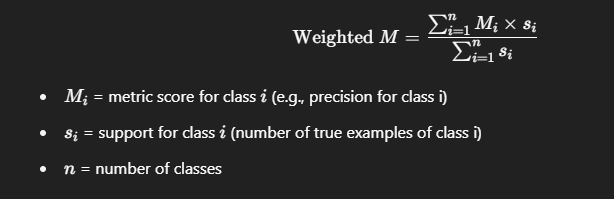

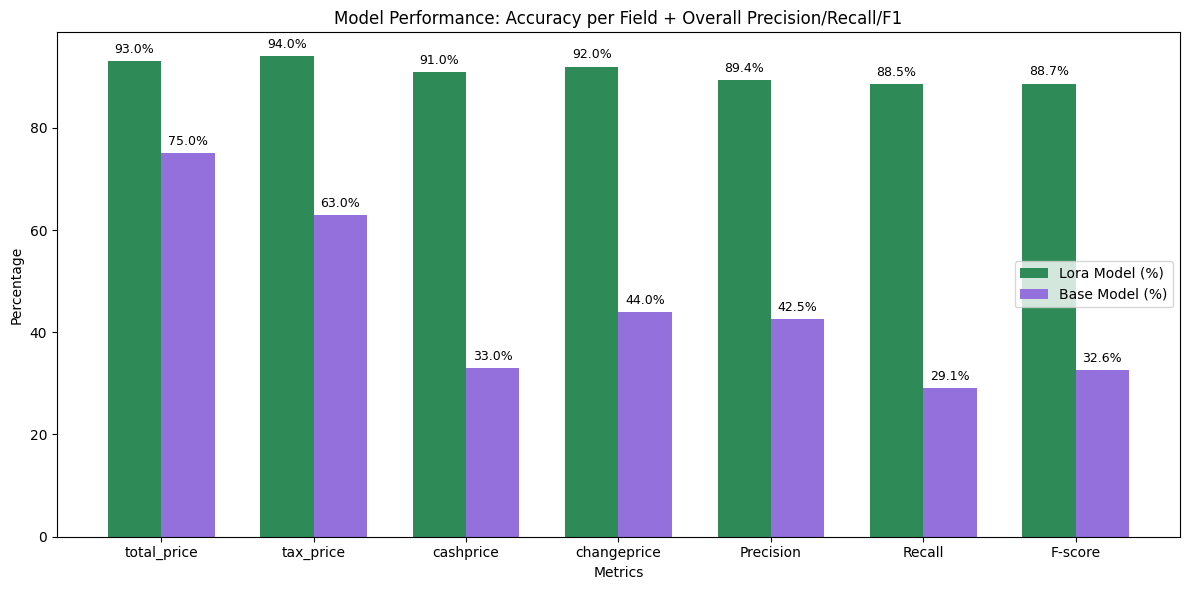

In [ ]:
def compute_overall_metrics(true_data, pred_data):
    """
    Compute overall precision, recall, and F1-score for all fields as a flat multi-class set.
    """
    true_flat = []
    pred_flat = []

    fields = ["total_price", "tax_price", "cashprice", "changeprice"]
    for image_name in true_data:
        true_vals = true_data[image_name]
        pred_vals = pred_data.get(image_name, [None]*len(fields))

        for t, p in zip(true_vals, pred_vals):
            if t is not None:
                true_flat.append(t)
                pred_flat.append(p if p is not None else "___")

    precision = precision_score(true_flat, pred_flat, average='weighted', zero_division=0) * 100
    recall = recall_score(true_flat, pred_flat, average='weighted', zero_division=0) * 100
    f1 = f1_score(true_flat, pred_flat, average='weighted', zero_division=0) * 100

    return precision, recall, f1

def plot_all_metrics(misses, total_samples, lora_metrics, base_metrics):
    """
    Plot bar chart with:
    - Accuracy per field for both models
    - Overall precision, recall, F1
    """
    labels = ['total_price', 'tax_price', 'cashprice', 'changeprice']
    lora_acc = [(total_samples - misses[field]["lora"]) / total_samples * 100 for field in labels]
    base_acc = [(total_samples - misses[field]["base"]) / total_samples * 100 for field in labels]

    # Add overall metrics
    metric_labels = labels + ['Precision', 'Recall', 'F-score']
    lora_all = lora_acc + list(lora_metrics)
    base_all = base_acc + list(base_metrics)

    x = np.arange(len(metric_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    lora_bars = ax.bar(x - width/2, lora_all, width, label='Lora Model (%)', color='seagreen')
    base_bars = ax.bar(x + width/2, base_all, width, label='Base Model (%)', color='mediumpurple')

    # Add percentages above bars
    for bar in lora_bars + base_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Percentage')
    ax.set_title('Model Performance: Accuracy per Field + Overall Precision/Recall/F1')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels)
    ax.legend()
    plt.tight_layout()
    plt.show()

# File paths
true_labels_path = "/adrive/MyDrive/Invoice_data/splits/test/test_models_output/processed/processed_true_labels.txt"
lora_model_out_path = "/adrive/MyDrive/Invoice_data/splits/test/test_models_output/processed/processed_lora_model_out.txt"
base_model_out_path = "/adrive/MyDrive/Invoice_data/splits/test/test_models_output/processed/processed_base_model_out.txt"

# Load the data
true_data = load_file(true_labels_path)
lora_data = load_file(lora_model_out_path)
base_data = load_file(base_model_out_path)

# Miss counts
misses = compare_samples(true_data, lora_data, base_data)

# Overall metrics
lora_overall = compute_overall_metrics(true_data, lora_data)
base_overall = compute_overall_metrics(true_data, base_data)

# Plot everything
plot_all_metrics(misses, len(true_data), lora_overall, base_overall)


# Message

In [ ]:
def load_and_resize_image_inf(image, max_size=600):
    # Ensure image is a PIL object
    if not isinstance(image, Image.Image):
        raise ValueError("Input must be a PIL Image object.")

    # Resize image if it exceeds max_size
    if max(image.size) > max_size:
        ratio = max_size / max(image.size)
        new_size = (int(image.size[0] * ratio), int(image.size[1] * ratio))
        image = image.resize(new_size, Image.LANCZOS)

    return image